# Coupled Oscillators with Half-Inverse Gradients

In this notebook, we'll turn to a practical example comparing the half-inverse gradients (HIGs) to other methods for training neural networks with physical loss functions. Specifically, we'll compare:

1. Adam: as a standard gradient-descent (GD) based network optimizer,
2. Scale-Invariant Physics: the previously described algorithm that fully inverts the physics,
3. Half-Inverse Gradients: which locally and jointly inverting physics and network.



## Inverse problem setup

The learning task is to find the control function steering the dynamics of a coupled oscillator system. 
This is a classical problem in physics, and a good case to evaluate the HIGs due to it's smaller size. We're using two mass points, and thus we'll only have four degrees of freedom for position and velocity of both points (compared to, e.g., the $32\times32\times2$ unknowns we'd get even for "only" a small fluid simulation with 32 cells along x and y). 

Nonetheless, the oscillators are a highly-non trivial case: we aim for applying a control such that the initial state is reached again after a chosen time interval. We'll use 24 steps of a fourth-order Runge-Kutta scheme, and hence the NN has to learn how to best "nudge" the two mass points over the course of all time steps, so that they end up at the desired position with the right velocity at the right time.

A system of $N$ coupled oscillators is described by the following Hamiltonian:

$$
  \mathcal{H}(x_i,p_i,t)=\sum_i \bigg( \frac{x_i^2}{2}+ \frac{p_i^2}{2} +  \alpha \cdot (x_i-x_{i+1})^4+u(t) \cdot x_i \cdot c_i\bigg),
$$

which provides the basis for the RK4 time integration below.




## Problem statement

More concretely, we consider a set of different phyiscal inputs ($x_i$). Using a corresponding control function ($u_i$), we can influence the time evolution of our physical system $\mathcal P$ and receive an output state ($y_i$).

$$y_i=\mathcal P(x_i;u_i)$$

If we want to evolve a given initial state($x_i$) into a given target state ($y^*_i$), we receive an inverse problem for the control function $(u_i)$. The quality of between desired target state ($y^*_i$) and received target state ($y_i$) is measured by a loss function ($L$).

$$\text{arg min}_{u_i}\; L(y^*_i,\mathcal P(x_i;u_i))$$

If we use a neural network ($f$ parameterized by $\theta$) to learn the control function over a set of input/output pairs ($x_i,y^*_i$), we transform the above physics optimization task into a learning problem.

$$\text{arg min}_{\theta}\; \sum_i L\big(y^*_i, \mathcal P(x_i;f(x_i,y_i; \theta)) \big)$$

Before we begin by setting up the physics solver $\mathcal P$, we import the necessary libraries (this example uses TensorFlow), and define the main global variable `MODE`, that switches between _Adam_ (`'GD'`), _Scale-invariant physics_ (`'SIP'`), and _Half-inverse gradients_ (`'HIG'`).

In [95]:
import numpy as np
import tensorflow as tf
import time, os

# main switch for the three methods:
MODE = 'HIG'  # HIG | SIP | GD

## Coupled linear oscillator simulation

For the physics simulation, we'll solve a differential equation for a system of coupled linear oscillators with a control term. The time integration, a fourth-order Runge-Kutta scheme is used.

Below, we're first defining a few global constants:
`Nx`: the number of oscillators,
`Nt`: the number of time evolution steps, and
`DT`: the length of one time step. 

We'll then define a helper function to set up a Laplacian stencil, the `coupled_oscillators_batch()` function which computes the simulation for a whole mini batch of values, and finally the `solver()` function, which runs the desired number of time steps with a given control signal.

In [96]:
Nx = 2
Nt = 24
DT = 0.5

def build_laplace(n,boundary='0'):
    if n==1:
        return np.zeros((1,1),dtype=np.float32)
    d1 = -2 * np.ones((n,),dtype=np.float32)
    d2 = 1 * np.ones((n-1,),dtype=np.float32)
    lap = np.zeros((n,n),dtype=np.float32)
    lap[range(n),range(n)]=d1
    lap[range(1,n),range(n-1)]=d2
    lap[range(n-1),range(1,n)]=d2
    if boundary=='0':
        lap[0,0]=lap[n-1,n-1]=-1

    return lap

@tf.function
def coupled_oscillators_batch( x, control):
    '''
    ODE of type:    x' = f(x)
    :param x_in:    position and velocities, shape: (batch, 2 * number of osc) order second index: x_i , v_i
    :param control: control function, shape: (batch,)
    :return:
    '''
    #print('coupled_oscillators_batch')
    n_osc = x.shape[1]//2

    # natural time evo
    a1 = np.array([[0,1],[-1,0]],dtype=np.float32)
    a2 = np.eye(n_osc,dtype=np.float32)
    A = np.kron(a1,a2)
    x_dot1 = tf.tensordot(x,A,axes = (1,1))

    # interaction term
    interaction_strength = 0.2
    b1 = np.array([[0,0],[1,0]],dtype=np.float32)
    b2 = build_laplace(n_osc)
    B = interaction_strength * np.kron(b1,b2)
    x_dot2 = tf.tensordot(x,B, axes=(1, 1))

    # control term
    control_vector = np.zeros((n_osc,),dtype=np.float32)
    control_vector[-1] = 1.0
    c1 = np.array([0,1],dtype=np.float32)
    c2 = control_vector
    C = np.kron(c1,c2)
    x_dot3 = tf.tensordot(control,C, axes=0)

    #all terms
    x_dot = x_dot1 + x_dot2 +x_dot3
    return x_dot

@tf.function
def runge_kutta_4_batch(x_0, dt, control, ODE_f_batch):

    f_0_0 = ODE_f_batch(x_0, control)
    x_14 = x_0 + 0.5 * dt * f_0_0

    f_12_14 = ODE_f_batch(x_14, control)
    x_12 = x_0 + 0.5 * dt * f_12_14

    f_12_12 = ODE_f_batch(x_12, control)
    x_34 = x_0 + dt * f_12_12

    terms = f_0_0 + 2 * f_12_14 + 2 * f_12_12 + ODE_f_batch(x_34, control)
    x1 = x_0 + dt * terms / 6

    return x1

@tf.function
def solver(x0, control):
    x = x0
    for i in range(Nt):
        x = runge_kutta_4_batch(x, DT, control[:,i], coupled_oscillators_batch)
    return x


## Training setup

The neural network itself is quite simple: it consists of four dense layers (the intermediate ones with 20 neurons each), and `tanh` activation functions.

In [97]:
act = tf.keras.activations.tanh
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(2*Nx)),
    tf.keras.layers.Dense(20, activation=act),
    tf.keras.layers.Dense(20, activation=act),
    tf.keras.layers.Dense(20, activation=act),
    tf.keras.layers.Dense(Nt, activation='linear')
    ])

As loss function, we'll use an $L^2$ loss:

In [98]:
@tf.function
def loss_function(a,b):
    diff = a-b
    loss_batch = tf.reduce_sum(diff**2,axis=1)
    loss = tf.reduce_sum(loss_batch)
    return loss

And as data set for training we simply create 4k of random position values which the oscillators start with (`X_TRAIN`), and which they should return to at the end of the simulation (`Y_TRAIN`). As they should return to their initial states, we have `X_TRAIN=Y_TRAIN`.



In [99]:
N = 2**12
X_TRAIN = np.random.rand(N, 2 * Nx).astype(np.float32)
Y_TRAIN = X_TRAIN # the target states are identical

## Training
For the optimization procedure of the neural network training, we need to set up some global parameters. The next cell initializes some suitable values tailored to each of the three methods. These were determined heuristically to work best for each. If we try to use the same settings for all, this would inevitably make the comparison unfair for some of them.

1. _Adam_: This is the most widely used NN optimizer, and we're using it here as a representative of the GD family. Note that the truncation parameter has no meaning for Adam.

2. _SIP_: The specified optimizer is the one used for network optimization. The physics inversion is done via Gauss-Newton and corresponds to an exact inversion since the physical optimization landscape is quadratic. For the Jacobian inversion in Gauss-Newton, we can specify a truncation parameter.

3. _HIG_: To obtain the HIG algorithm, the optimizer has to be set to SGD. For the Jacobian half-inversion, we can specify a truncation parameter. Optimal batch sizes are typically lower than for the other two, and a learning rate of 1 typically works very well.

The maximal training time in seconds is set via `MAX_TIME` below.

In [100]:
if MODE=='HIG': # HIG training
  OPTIMIZER = tf.keras.optimizers.SGD
  BATCH_SIZE = 32 # larger batches make HIGs unnecessariy slow...
  LR = 1.0
  TRUNC = 10**-10

elif MODE=='SIP': # SIP training
  OPTIMIZER = tf.keras.optimizers.Adam
  BATCH_SIZE = 256
  LR = 0.001  # for the internal step with Adam
  TRUNC = 0   # not used

else: #  Adam Training (as GD representative)
  MODE = 'GD' 
  OPTIMIZER = tf.keras.optimizers.Adam
  BATCH_SIZE = 256
  LR = 0.001
  TRUNC = 0 # not used

# global parameters for all three methods
MAX_TIME = 100 # [s]
print("Running variant: "+MODE)

Running variant: HIG


The next function, `HIG_pinv()`, is a crucial one: it constructs the half-inverse of a given matrix for HIGs. It computes an SVD, takes the square-root of the singular values, and then re-assembles the matrix. 

In [101]:
from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.util import dispatch
from tensorflow.python.util.tf_export import tf_export
from tensorflow.python.ops.linalg.linalg_impl import _maybe_validate_matrix,svd

# partial inversion of the Jacobian via SVD:
# this function is adopted from tensorflow's SVD function, and published here under its license: Apache-2.0 License , https://github.com/tensorflow/tensorflow/blob/master/LICENSE
@tf_export('linalg.HIG_pinv')
@dispatch.add_dispatch_support
def HIG_pinv(a, rcond=None,beta=0.5, validate_args=False, name=None):

  with ops.name_scope(name or 'pinv'):
    a = ops.convert_to_tensor(a, name='a')

    assertions = _maybe_validate_matrix(a, validate_args)
    if assertions:
      with ops.control_dependencies(assertions):
        a = array_ops.identity(a)

    dtype = a.dtype.as_numpy_dtype

    if rcond is None:

      def get_dim_size(dim):
        dim_val = tensor_shape.dimension_value(a.shape[dim])
        if dim_val is not None:
          return dim_val
        return array_ops.shape(a)[dim]

      num_rows = get_dim_size(-2)
      num_cols = get_dim_size(-1)
      if isinstance(num_rows, int) and isinstance(num_cols, int):
        max_rows_cols = float(max(num_rows, num_cols))
      else:
        max_rows_cols = math_ops.cast(
            math_ops.maximum(num_rows, num_cols), dtype)
      rcond = 10. * max_rows_cols * np.finfo(dtype).eps

    rcond = ops.convert_to_tensor(rcond, dtype=dtype, name='rcond')

    [ singular_values, left_singular_vectors, right_singular_vectors, ] = svd(
        a, full_matrices=False, compute_uv=True)

    cutoff = rcond * math_ops.reduce_max(singular_values, axis=-1)
    singular_values = array_ops.where_v2(
        singular_values > array_ops.expand_dims_v2(cutoff, -1), singular_values**beta,
        np.array(np.inf, dtype))

    a_pinv = math_ops.matmul(
        right_singular_vectors / array_ops.expand_dims_v2(singular_values, -2),
        left_singular_vectors,
        adjoint_b=True)

    if a.shape is not None and a.shape.rank is not None:
      a_pinv.set_shape(a.shape[:-2].concatenate([a.shape[-1], a.shape[-2]]))

    return a_pinv

Now we have all pieces in place to run the training. The next cell defines a Python class to organize the neural network optimization. It receives the physics solver, network model, loss function and a data set, and runs as many epochs as possible within the given time limit `MAX_TIME`.

Depending on the chosen optimization method, the mini batch updates differ:
1. Adam: Compute loss gradient, then apply the Adam update.
2. PG: Compute loss gradient und physics Jacobian, invert them data-point-wise, and compute network updates via the proxy loss and Adam.
3. HIG: Compute loss gradient and network-physics Jacobian, then jointly compute the half-inversion, and update the network parameters with the resulting step.

The `mini_batch_update()` method of the optimizer class realizes these three variants.

In [102]:
class Optimization():
    def __init__(self,model,solver,loss_function,x_train,y_train):
        self.model = model
        self.solver = solver
        self.loss_function = loss_function
        self.x_train = x_train
        self.y_train = y_train
        self.y_dim = y_train.shape[1]
        self.weight_shapes = [weight_tensor.shape for weight_tensor in self.model.trainable_weights]

    def set_params(self,batch_size,learning_rate,optimizer,max_time,mode,trunc):
        self.number_of_batches = N // batch_size
        self.max_time = max_time
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.optimizer = optimizer(learning_rate)
        self.mode = mode
        self.trunc = trunc


    def computation(self,x_batch, y_batch):
        control_batch = self.model(y_batch)
        y_prediction_batch = self.solver(x_batch,control_batch)
        loss = self.loss_function(y_batch,y_prediction_batch)
        return loss


    @tf.function
    def gd_get_derivatives(self,x_batch, y_batch):

        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.model.trainable_variables)
            loss = self.computation(x_batch,y_batch)
            loss_per_dp = loss / self.batch_size
        grad = tape.gradient(loss_per_dp, self.model.trainable_variables)
        return grad


    @tf.function
    def pg_get_physics_derivatives(self,x_batch, y_batch): # physics gradient for SIP

        with tf.GradientTape(persistent=True) as tape:
            control_batch = self.model(y_batch)
            tape.watch(control_batch)
            y_prediction_batch = self.solver(x_batch,control_batch)
            loss = self.loss_function(y_batch,y_prediction_batch)
            loss_per_dp = loss / self.batch_size

        jacy = tape.batch_jacobian(y_prediction_batch,control_batch)
        grad = tape.gradient(loss_per_dp, y_prediction_batch)
        return jacy,grad,control_batch

    @tf.function
    def pg_get_network_derivatives(self,x_batch, y_batch,new_control_batch): #physical grads

        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.model.trainable_variables)
            control_batch = self.model(y_batch)
            loss = self.loss_function(new_control_batch,control_batch)
            #y_prediction_batch = self.solver(x_batch,control_batch)
            #loss = self.loss_function(y_batch,y_prediction_batch)
            loss_per_dp = loss / self.batch_size

        network_grad = tape.gradient(loss_per_dp, self.model.trainable_variables)
        return network_grad

    @tf.function
    def hig_get_derivatives(self,x_batch,y_batch):

        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.model.trainable_variables)
            control_batch = self.model(y_batch)
            y_prediction_batch = self.solver(x_batch,control_batch)
            loss = self.loss_function(y_batch,y_prediction_batch)
            loss_per_dp = loss / self.batch_size

        jacy = tape.jacobian(y_prediction_batch, self.model.trainable_variables, experimental_use_pfor=True)
        loss_grad = tape.gradient(loss_per_dp, y_prediction_batch)
        return jacy, loss_grad


    def mini_batch_update(self,x_batch, y_batch):
        if self.mode=="GD":
            grad = self.gd_get_derivatives(x_batch, y_batch)
            self.optimizer.apply_gradients(zip(grad, self.model.trainable_weights))

        elif self.mode=="SIP":
            jacy,grad,control_batch = self.pg_get_physics_derivatives(x_batch, y_batch)
            grad_e = tf.expand_dims(grad,-1)
            pinv = tf.linalg.pinv(jacy,rcond=10**-5)
            delta_control_label_batch = (pinv@grad_e)[:,:,0]
            new_control_batch = control_batch - delta_control_label_batch
            network_grad = self.pg_get_network_derivatives(x_batch, y_batch,new_control_batch)
            self.optimizer.apply_gradients(zip(network_grad, self.model.trainable_weights))

        elif self.mode =='HIG':
            jacy, grad = self.hig_get_derivatives(x_batch, y_batch)
            flat_jacy_list = [tf.reshape(jac, (self.batch_size * self.y_dim, -1)) for jac in jacy]
            flat_jacy = tf.concat(flat_jacy_list, axis=1)
            flat_grad = tf.reshape(grad, (-1,))
            inv = HIG_pinv(flat_jacy, rcond=self.trunc)
            processed_derivatives = tf.tensordot(inv, flat_grad, axes=(1, 0))
            #processed_derivatives = self.linear_solve(flat_jacy, flat_grad)
            update_list = []
            l1 = 0
            for k, shape in enumerate(self.weight_shapes):
                l2 = l1 + np.prod(shape)
                upd = processed_derivatives[l1:l2]
                upd = np.reshape(upd, shape)
                update_list.append(upd)
                l1 = l2
            self.optimizer.apply_gradients(zip(update_list, self.model.trainable_weights))


    def epoch_update(self):
        for batch_index in range(self.number_of_batches):
            position = batch_index * self.batch_size
            x_batch = self.x_train[position:position + self.batch_size]
            y_batch = self.y_train[position:position + self.batch_size]
            self.mini_batch_update(x_batch, y_batch)

    def eval(self,epoch,wc_time,ep_dur):
        train_loss = self.computation(self.x_train,self.y_train)
        train_loss_per_dp = train_loss / N
        if epoch<5 or epoch%20==0: print('Epoch: ', epoch,', wall clock time: ',wc_time,', loss: ', float(train_loss_per_dp) )
        #print('TrainLoss:', train_loss_per_dp)
        #print('Epoch: ', epoch,' WallClockTime: ',wc_time,' EpochDuration: ',ep_dur )
        return train_loss_per_dp

    def start_training(self):
        init_loss = self.eval(0,0,0)
        init_time = time.time()
        time_list = [init_time]
        loss_list = [init_loss]

        epoch=0
        wc_time = 0

        while wc_time<self.max_time:
            
            duration = time.time()
            self.epoch_update()
            duration = time.time()-duration

            epoch += 1
            wc_time += duration

            loss = self.eval(epoch,wc_time,duration)
            time_list.append(duration)
            loss_list.append(loss)

        time_list = np.array(time_list)
        loss_list = np.array(loss_list)
        time_list[0] = 0
        return time_list, loss_list

All that's left to do is to start the training with the chosen global parameters, and collect the results in `time_list`, and `loss_list`.

In [103]:
opt = Optimization(model, solver, loss_function, X_TRAIN, Y_TRAIN)
opt.set_params(BATCH_SIZE, LR, OPTIMIZER, MAX_TIME, MODE, TRUNC)
time_list, loss_list = opt.start_training()

Epoch:  0 , wall clock time:  0 , loss:  1.4401766061782837
Epoch:  1 , wall clock time:  28.06755018234253 , loss:  5.44398972124327e-05
Epoch:  2 , wall clock time:  31.38792371749878 , loss:  1.064436037268024e-05
Epoch:  3 , wall clock time:  34.690271854400635 , loss:  3.163525434501935e-06
Epoch:  4 , wall clock time:  37.9914448261261 , loss:  1.1857609933940694e-06



## Evaluation

Now we can evaluate how our training converged over time. The following graph shows the loss evolution over time in seconds.

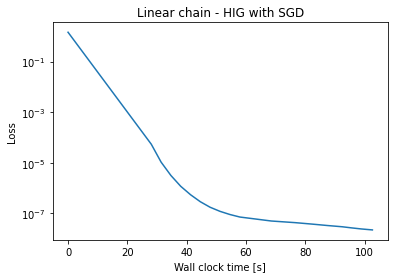

In [104]:
import matplotlib.pyplot as plt

plt.plot(np.cumsum(time_list),loss_list)
plt.yscale('log')
plt.xlabel('Wall clock time [s]'); plt.ylabel('Loss')
plt.title('Linear chain - '+MODE+' with '+str(OPTIMIZER.__name__))
plt.show()

For all three methods, you'll see a big linear step right at the start. As we're -- for fairness -- measuring the whole runtime, this first step includes all TensorFlow initialization steps, which are significantly more involved for HIG and SIP. Adam is much faster in terms of initialization, and likewise faster per training iteration.

All three methods by themselves manage to bring down the loss. What's more interesting is to see how they compare. For this, the next cell stores the training evolution, and this notebook needs to be run one time with each of the three methods to produce the final comparison graph.

In [105]:
path = '/home/'
namet = 'time'
namel = 'loss'
np.savetxt(path+MODE+namet+'.txt',time_list)
np.savetxt(path+MODE+namel+'.txt',loss_list)

After runs with each of the methods, we can show them side by side:

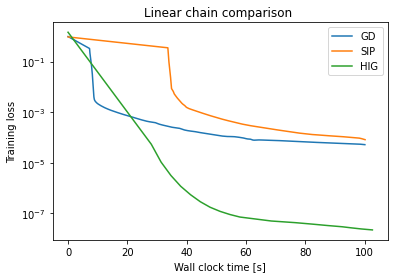

In [106]:
from os.path import exists

# if previous runs are available, compare all 3
if exists(path+'HIG'+namet+'.txt') and exists(path+'HIG'+namel+'.txt') and exists(path+'SIP'+namet+'.txt') and exists(path+'SIP'+namel+'.txt') and exists(path+'GD'+namet+'.txt') and exists(path+'GD'+namel+'.txt'):
  lt_hig = np.loadtxt(path+'HIG'+namet+'.txt')
  ll_hig = np.loadtxt(path+'HIG'+namel+'.txt')

  lt_sip = np.loadtxt(path+'SIP'+namet+'.txt')
  ll_sip = np.loadtxt(path+'SIP'+namel+'.txt')

  lt_gd = np.loadtxt(path+'GD'+namet+'.txt')
  ll_gd = np.loadtxt(path+'GD'+namel+'.txt')

  plt.plot(np.cumsum(lt_gd),ll_gd,   label="GD")
  plt.plot(np.cumsum(lt_sip),ll_sip, label="SIP")
  plt.plot(np.cumsum(lt_hig),ll_hig,   label="HIG")
  plt.yscale('log')
  plt.xlabel('Wall clock time [s]'); plt.ylabel('Training loss'); plt.legend()
  plt.title('Linear chain comparison ')
  plt.show()
else:
  print("Run this notebook three times with MODE='HIG|SIP|GD' to produce the final graph")


This graph makes the significant differences in terms of convergence very clear: Adam (the blue `GD` curve), performs a large number of updates, but its rough approximation of the Hessian is not enough to converge to high accuracies. It stagnates at a high loss level.

The SIP updates don't outperform Adam in this scenario. This is caused by the relatively simple physics (the _linear_ oscillators), and the higher runtime cost of SIP. If you run this example longer, SIP will actually overtake Adam, but start suffering from numerical issues with the full inversion.

The HIGs perform much better than the two others: despite being fairly slow per iteration, the half-inversion produces a very good update, that makes the training converge to very low loss values very quickly. The HIGs reach an accuracy that is around four order of magnitudes better than the other two methods.

## Next steps

There's a variety of interesting directions for further tests and modifications with this notebook:

* Most importantly, we've actually only looked at training performance so far! This keeps the notebook reasonably short, but it's admittedly bad practice. While we claim that HIGs likewise work on _real_ test data, this is a great next step with this notebook: allocate proper test samples, and re-run the evaluation for all three methods on the test data.
* Also, you can vary the physics behavior: use more oscillators for longer or shorter time spans, or even include a non-linear force (as employed in the HIG paper). Be warned: for the latter, the SIP version will require a new inverse solver, though.